# Disaster Tweets

## Problem Statement

* blah blah

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df_train=pd.read_csv(r"/kaggle/input/nlp-getting-started/train.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.shape

(7613, 5)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


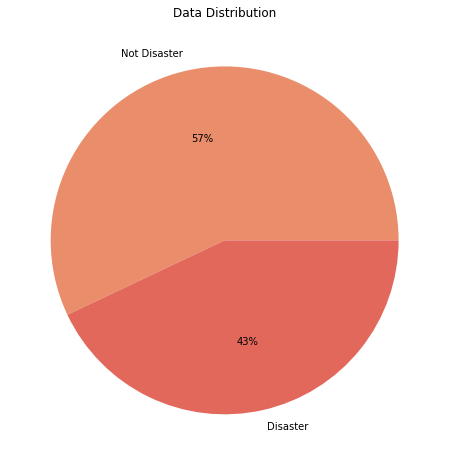

In [7]:
plt.figure(figsize=(8,8))
colors = sns.color_palette('flare')
plt.pie(x=df_train["target"].value_counts().values,labels=["Not Disaster", "Disaster"],autopct='%.0f%%', colors=colors)
plt.title("Data Distribution")
plt.show()

* The data doesn't seem to be awfully misbalanced
* Both of the classes have an _almost_ equal distribution. So we don't need to worry about creating a balanced dataset by either subsampling the data or some other data augmentation technique.

#### Handling Missing Values

In [8]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df_train.isnull().sum() / len(df_train) * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

- `keyword` column is missing less than 1% values
- `location` column is missing more. than 33% of its values

There are multiple solutions on handling this situation. For now,
- I'll be dropping the `location` column altogether since keeping it in might throw-off the model. It could potentially take _absense_ of location keyword as an important factor for a disaster or a not disaster tweet.
- For the `keyword` column, we can drop the rows with null values in them since our dataset is relatively huge.

In [10]:
df_train = df_train.drop(columns=['location'])

In [11]:
df_train = df_train.dropna(subset=['keyword'])

In [12]:
df_train.shape

(7552, 4)

- As expected, the number of rows in training dataset drops from 7613 to 7552. 
- This is not a huge drop, we can continue on with our analysis

#### Keywords

In [13]:
keyword_distribution = df_train['keyword'].value_counts()
keyword_distribution[:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

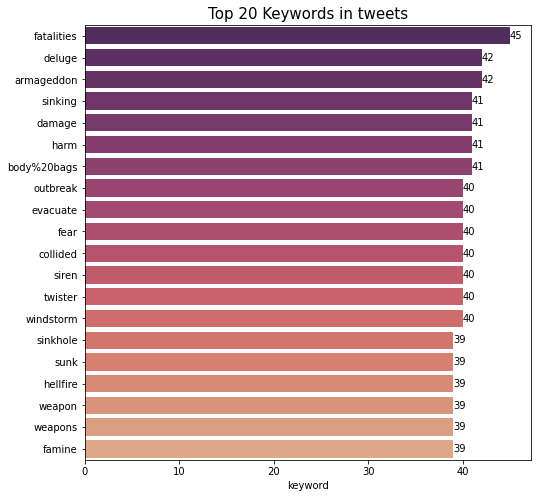

In [14]:
plt.figure(figsize=(8,8))

top_20_keywords=df_train['keyword'].value_counts()[:20]
ax = sns.barplot(y=top_20_keywords.index,x=top_20_keywords,palette='flare_r',data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 Keywords in tweets',fontsize=15)
plt.show()

#### Keywords - Disaster vs Not Disaster

In [15]:
keywords_disaster = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()
keywords_not_disaster = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()

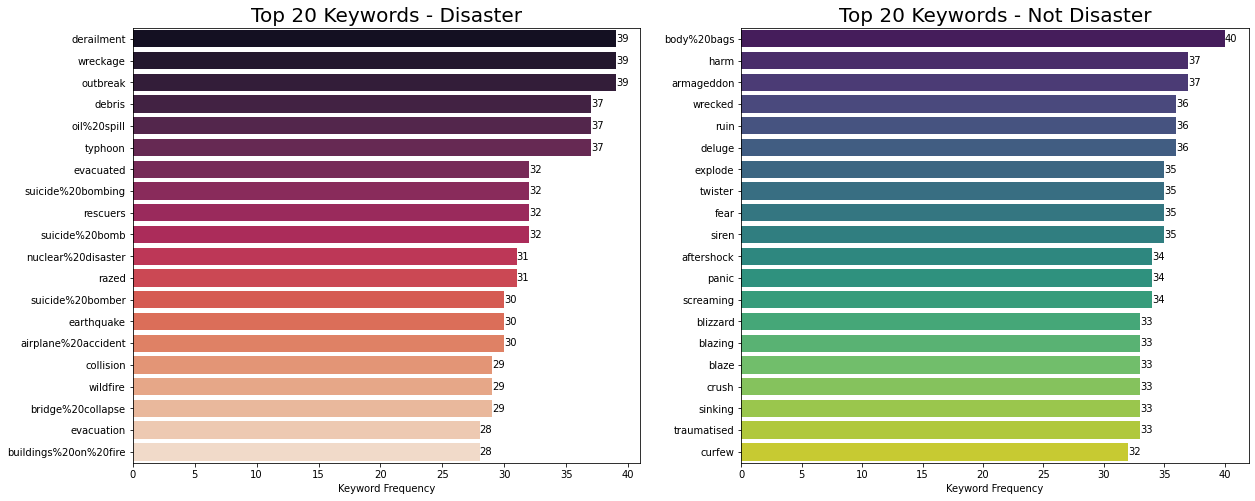

In [16]:
# plt.figure(figsize=(20,8))
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.barplot(y=keywords_disaster[0:20].index, x=keywords_disaster[0:20], orient='h', ax=ax[0], palette="rocket")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Top 20 Keywords - Disaster",fontsize=20)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=keywords_not_disaster[0:20].index, x= keywords_not_disaster[0:20], orient='h', ax=ax[1], palette="viridis")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Top 20 Keywords - Not Disaster",fontsize=20)
ax[1].set_xlabel("Keyword Frequency")


plt.show()

#### Tweet Length and Word Counts

* Twitter has traditionally always had a hard limit of 140 character for tweets. Only a few years ago did they double the limit to 280.

In [17]:
df_train["length"] = df_train["text"].str.len()
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))

In [18]:
df_train.head()

,id,keyword,text,target,length,word_count
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13


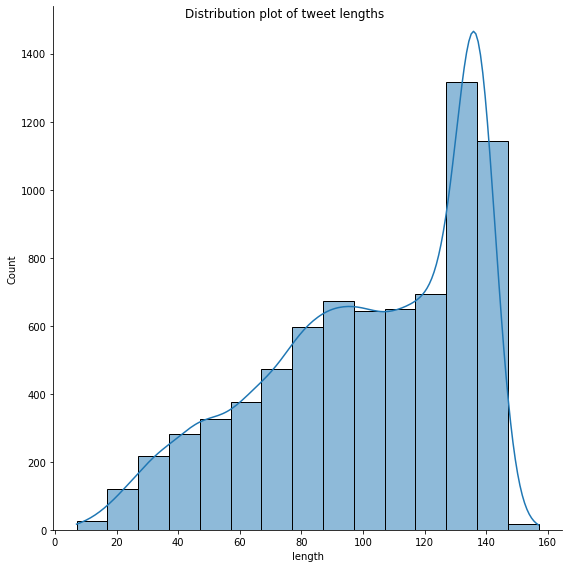

In [19]:
ax = sns.displot(df_train["length"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of tweet lengths')
plt.show()

In [20]:
df_train['length'].describe()

count    7552.000000
mean      101.256488
std        33.579745
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

* Average tweet length is 101 characters
* Longest tweet is 157 characters long

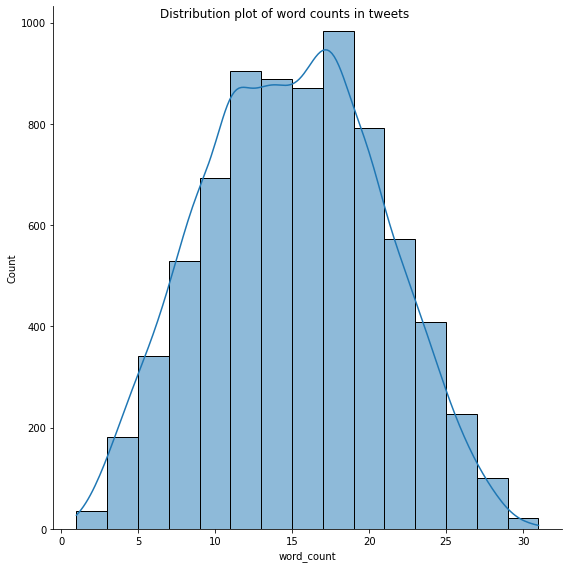

In [21]:
ax = sns.displot(df_train["word_count"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of word counts in tweets')
plt.show()

In [22]:
df_train['word_count'].describe()

count    7552.000000
mean       14.931806
std         5.715034
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

* Average number of words per tweet is approx 15
* Max number of words per tweet is 31

### Preprocessing text for a ML Model

Cleanup process:
- Remove stopwords (from `nltk` library)
- Remove punctuations
- Since we're dealing with raw tweets data, we'll also remove any emojis using `regex`
- Apply a stemming algorithm (`Porter` from `nltk` library)
- Perform TF-IDF vectorization

What is stemming?
- Stemming is the process of reducing variants to a root word
- For example: chocolates, chocolatey, choco can all be reduced to the same root word - `chocolate`

What is TF-IDF?
- TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency.
- It converts text into meaningful representation of numbers which is used to fit ML algorithms for prediction.

In [23]:
nltk_stopwords = stopwords.words('english')

def remove_stopwords(row):
    # convert the whole tweet to lowercase
    text = row.lower()
    
    # keep only alphabets
    # remove punctuations, numbers
    text = re.sub('[^a-z]', ' ', text)
    
    # remove emojis
    # code for removing emojis from - https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
    
    # split out the tweet into a list
    # ex: "hello world !" -> ["hello", "world", "!"]
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in nltk_stopwords]
    
    return ' '.join(text)

In [24]:
# let's test the function with "Hello world is the ! \U0001f602" 
# \U0001f602 is the smiling emoji
# these 3 items should be removed: is, the, !, \U0001f602
remove_stopwords("hello world is the ! \U0001f602")

'hello world'

In [25]:
df_train["clean_text"] = df_train["text"].apply(remove_stopwords)

In [26]:
df_train.head()

,id,keyword,text,target,length,word_count,clean_text
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,bbcmtd wholesale markets ablaze http co lhyxeo...
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10,always try bring heavy metal rt http co yao e ...
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,africanbaze breaking news nigeria flag set abl...
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7,crying set ablaze
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,plus side look sky last night ablaze http co q...


In [27]:
port_stem = PorterStemmer()

def port_stemmer(row):
    text = row.split()
    
    text = [port_stem.stem(word) for word in text]
    
    return ' '.join(text)

In [28]:
df_train["clean_stemmed_text"] = df_train["clean_text"].apply(port_stemmer)

In [29]:
df_train.head()

,id,keyword,text,target,length,word_count,clean_text,clean_stemmed_text
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,bbcmtd wholesale markets ablaze http co lhyxeo...,bbcmtd wholesal market ablaz http co lhyxeohi c
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10,always try bring heavy metal rt http co yao e ...,alway tri bring heavi metal rt http co yao e xngw
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,africanbaze breaking news nigeria flag set abl...,africanbaz break news nigeria flag set ablaz a...
34,52,ablaze,Crying out for more! Set me ablaze,0,34,7,crying set ablaze,cri set ablaz
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,plus side look sky last night ablaze http co q...,plu side look sky last night ablaz http co qqs...


#### Convert the cleaned text data into one hot embeddings

In [56]:
one_hot_list = [one_hot(row, 5000) for row in df_train["clean_stemmed_text"].values]

In [60]:
df_train["clean_stemmed_text"].values[0]

'bbcmtd wholesal market ablaz http co lhyxeohi c'

In [59]:
one_hot_list[0]

[1891, 4019, 1537, 2596, 1343, 3912, 1639, 3757]

In [62]:
embedded_docs = pad_sequences(one_hot_list, padding='pre', maxlen=31)

### Model Architecture

#### Split the data into train & validation sets

In [65]:
# X = df_vec.drop("target", axis=1)
X = np.array(embedded_docs)
y = np.array(df_vec["target"])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [66]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((5664, 31), (5664,), (1888, 31), (1888,))

#### Train the ML Model

In [107]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [68]:
model = Sequential()

model.add(Embedding(5001, 40, input_length=31))
model.add(Dropout(0.2))
model.add(LSTM(256, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 31, 40)            200040    
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 40)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               304128    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 504,425
Trainable params: 504,425
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/20
177/177 [==============================] - 2s 7ms/step - loss: 0.5739 - accuracy: 0.6940 - val_loss: 0.5115 - val_accuracy: 0.7707
Epoch 2/20
177/177 [==============================] - 1s 5ms/step - loss: 0.3916 - accuracy: 0.8312 - val_loss: 0.4821 - val_accuracy: 0.7855
Epoch 3/20
177/177 [==============================] - 1s 5ms/step - loss: 0.2976 - accuracy: 0.8780 - val_loss: 0.5428 - val_accuracy: 0.7786
Epoch 4/20
177/177 [==============================] - 1s 5ms/step - loss: 0.2321 - accuracy: 0.9105 - val_loss: 0.5796 - val_accuracy: 0.7458
Epoch 5/20
177/177 [==============================] - 1s 5ms/step - loss: 0.1773 - accuracy: 0.9338 - val_loss: 0.7683 - val_accuracy: 0.7574
Epoch 6/20
177/177 [==============================] - 1s 5ms/step - loss: 0.1278 - accuracy: 0.9566 - val_loss: 0.8228 - val_accuracy: 0.7357
Epoch 7/20
177/177 [==============================] - 1s 5ms/step - loss: 0.0945 - accuracy: 0.9673 - val_loss: 0.8496 - val_accuracy: 0.7251
Epoch 

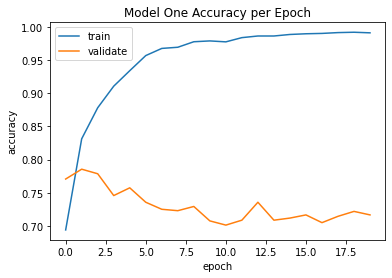

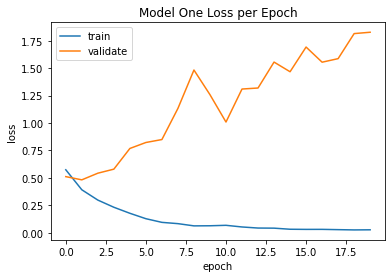

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

- The accuracy for`validation` set goes down sharply as # of epochs go up.
- We can try the following next
    - Add `EarlyStopping` callback function to stop training if validation accuracy goes down for multiple epochs
    - Add `ReduceLROnPlateau` callback function to reduce learning rate if validation accuracy pleataus 
    - Increase the # of LSTM layers
    - Add more cells in each LSTM layer
- The model might be overfitting since `train_acc` increases but `val_acc` decreases with an increase in # of epochs. Potential fixes:
    - Add more dropout layers
    - Reduce the learning rate
    

In [166]:
model2 = Sequential()

model2.add(Embedding(5001, 40, input_length=31))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(400, return_sequences=True)))
# model2.add(Dropout(0.25))
model2.add(Bidirectional(LSTM(200, return_sequences=True)))
# model2.add(Dropout(0.25))
# model2.add(Bidirectional(LSTM(400, return_sequences=True)))
# model2.add(Dropout(0.25))
model2.add(LSTM(200))
model2.add(Dropout(0.25))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(1e-5)
model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [167]:
model2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 31, 40)            200040    
_________________________________________________________________
dropout_75 (Dropout)         (None, 31, 40)            0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 31, 800)           1411200   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 31, 400)           1601600   
_________________________________________________________________
lstm_80 (LSTM)               (None, 200)               480800    
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)              

In [168]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=1e-6)
                              
                              
callbacks_list = [early_stop, reduce_lr]

In [169]:
history2 = model2.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_validation, y_validation), callbacks=callbacks_list)

Epoch 1/40
177/177 [==============================] - 11s 30ms/step - loss: 0.6855 - accuracy: 0.5704 - val_loss: 0.6748 - val_accuracy: 0.5752
Epoch 2/40
177/177 [==============================] - 4s 23ms/step - loss: 0.6701 - accuracy: 0.5715 - val_loss: 0.6633 - val_accuracy: 0.5747
Epoch 3/40
177/177 [==============================] - 4s 24ms/step - loss: 0.6503 - accuracy: 0.5973 - val_loss: 0.6408 - val_accuracy: 0.6266
Epoch 4/40
177/177 [==============================] - 4s 23ms/step - loss: 0.6388 - accuracy: 0.6370 - val_loss: 0.6360 - val_accuracy: 0.6488
Epoch 5/40
177/177 [==============================] - 4s 24ms/step - loss: 0.6329 - accuracy: 0.6538 - val_loss: 0.6291 - val_accuracy: 0.6510
Epoch 6/40
177/177 [==============================] - 4s 23ms/step - loss: 0.6218 - accuracy: 0.6637 - val_loss: 0.6225 - val_accuracy: 0.6578
Epoch 7/40
177/177 [==============================] - 4s 22ms/step - loss: 0.6115 - accuracy: 0.6730 - val_loss: 0.6164 - val_accuracy: 0.662

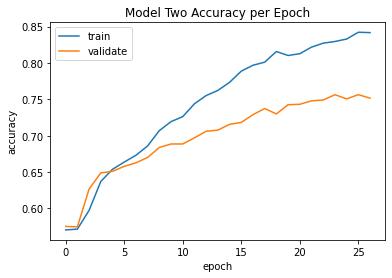

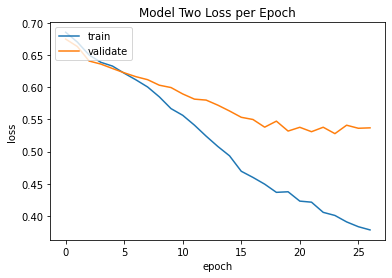

In [171]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Two Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Two Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();